In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!pwd
%cd /content/drive/MyDrive/Colab Notebooks/assign10

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
/content/drive/MyDrive/Colab Notebooks/assign10


In [3]:
from dataset.mnist import load_mnist

(train_raw_img, train_y), (test_raw_img, test_y) = load_mnist(flatten=False, normalize=False)

# reshape
train_X = train_raw_img.reshape(len(train_raw_img.squeeze()), -1)
test_X = test_raw_img.reshape(len(test_raw_img.squeeze()), -1)

In [4]:
# preprocessing : normalization(set 0~1) + dimension reduction using PCA

train_X = train_X.astype('float')/255
test_X = test_X.astype('float')/255

In [5]:
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


In [6]:
def power_iteration(X, num_iter, epsilon = 1e-10) :

    X_centered = X - np.mean(X, axis=0)   # Data centered
    A = np.cov(X_centered, rowvar=False)  # Construct covariance matrix

    M, N = X.shape
    convert_matrix = np.zeros((N, num_iter))  # Initializing conversion matrix

    for k in range(num_iter) :    # Power iteration
      b = np.ones(N) / np.sqrt(N) # eigen vector
      while True :
        b_next = np.dot(A, b) / np.linalg.norm(np.dot(A, b))

        if np.linalg.norm(b_next - b) < epsilon :
          break

        b = b_next

      eigen_value = np.dot(b_next, np.dot(A, b_next)) # Compute eigen value
      A -= eigen_value * np.outer(b_next, b_next)     # Update A

      convert_matrix[:, k] = b_next # Save the eigen vector in Convert matrix

    return convert_matrix

In [7]:
convert_matrix = power_iteration(train_X, 5)

train_X = np.dot(train_X, convert_matrix)
test_X = np.dot(test_X, convert_matrix)

In [8]:
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(60000, 5) (60000,)
(10000, 5) (10000,)


In [9]:
def downsample_dataset(X, y, sample_size) :
    indices = np.random.choice(len(X), size = sample_size, replace = False)
    sampled_X = X[indices]
    sampled_y = y[indices]

    return sampled_X, sampled_y

In [10]:
sample_size = 1000
train_X, train_y = downsample_dataset(train_X, train_y, sample_size)

print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(1000, 5) (1000,)
(10000, 5) (10000,)


In [11]:
def entropy(y):
    epsilon = 1e-10

    unique_classes, class_counts = np.unique(y, return_counts=True)
    total_examples = len(y)

    probabilities = class_counts / total_examples

    entropy = -np.sum(probabilities * np.log2(probabilities + epsilon))

    return entropy

In [12]:
def information_gain(y, y_left, y_right):
    entropy_y = entropy(y)
    entropy_left = entropy(y_left)
    entropy_right = entropy(y_right)

    n = len(y)
    n_left = len(y_left)
    n_right = len(y_right)

    gain = entropy_y - (n_left / n) * entropy_left - (n_right / n) * entropy_right

    return gain

In [13]:
def make_tree(X, y, max_depth, depth=0) :
    if depth == max_depth or len(np.unique(y)) == 1 : # stopping conditions
        return {'class' : np.argmax(np.bincount(y))} # return class

    best_feature, best_threshold = find_best_split(X, y)
    left_mask = X[:, best_feature] <= best_threshold
    right_mask = X[:, best_feature] > best_threshold
    left_node = make_tree(X[left_mask], y[left_mask], max_depth, depth + 1)
    right_node = make_tree(X[right_mask], y[right_mask], max_depth, depth + 1)

    return {'feature': best_feature, 'threshold': best_threshold, 'left': left_node, 'right': right_node}

def find_best_split(X, y):
    best_gain = -1
    best_feature = None
    best_threshold = None

    for feature_idx in range(X.shape[1]):
        feature_values = X[:, feature_idx]
        thresholds = np.unique(feature_values)

        for threshold in thresholds:
            y_left = y[feature_values <= threshold]
            y_right = y[feature_values > threshold]

            if len(y_left) == 0 or len(y_right) == 0:
                continue

            gain = information_gain(y, y_left, y_right)

            if gain > best_gain:
                best_gain = gain
                best_feature = feature_idx
                best_threshold = threshold

    return best_feature, best_threshold

In [14]:
def prediction(x, node) :
    if 'class' in node :
        return node['class']

    feature = node['feature']
    threshold = node['threshold']

    if x[feature] <= threshold:
        return prediction(x, node['left'])
    else:
        return prediction(x, node['right'])

In [15]:
# early stopping
chart_train1 = []
chart_test1 = []

for i in range(1, 7) :
  model_base = make_tree(train_X, train_y, max_depth = i)
  pred1 = np.array([prediction(x, model_base) for x in train_X])
  pred2 = np.array([prediction(x, model_base) for x in test_X])

  print('early stopping in train set {',i,'} :', np.mean(pred1==train_y))
  chart_train1.append(np.mean(pred1==train_y))
  print('early stopping in test set {',i,'}:', np.mean(pred2==test_y))
  chart_test1.append(np.mean(pred2==test_y))
  print()

early stopping in train set { 1 } : 0.218
early stopping in test set { 1 }: 0.204

early stopping in train set { 2 } : 0.328
early stopping in test set { 2 }: 0.3026

early stopping in train set { 3 } : 0.459
early stopping in test set { 3 }: 0.4324

early stopping in train set { 4 } : 0.549
early stopping in test set { 4 }: 0.5158

early stopping in train set { 5 } : 0.64
early stopping in test set { 5 }: 0.5751

early stopping in train set { 6 } : 0.706
early stopping in test set { 6 }: 0.5963



### bagging

In [17]:
def bagging_with_decision_trees(X, y, num_trees, max_depth) :

    models = []

    for _ in range(num_trees) :
        bootstrap_idx = np.random.choice(len(X), size=len(X), replace=True)
        bootstrap_X, bootstrap_y = X[bootstrap_idx], y[bootstrap_idx]
        model = make_tree(bootstrap_X, bootstrap_y, max_depth)
        models.append(model)

    return models

In [18]:
def majority_voting(predictions) :
    counts = {}

    for prediction in predictions :
        if prediction in counts :
            counts[prediction] += 1
        else :
            counts[prediction] = 1

    majority_prediction = max(counts, key=counts.get)
    return majority_prediction

In [19]:
def predict_bagging(models, X) :
    predictions = []

    for model in models :
        model_predictions = []
        for x in X :
            pred = prediction(x, model)
            model_predictions.append(pred)
        predictions.append(model_predictions)

    final_prediction = np.apply_along_axis(majority_voting, axis=0, arr=predictions)

    return final_prediction

chart_bag = []

for i in range(1, 7) :
    models = bagging_with_decision_trees(train_X, train_y, num_trees = 6, max_depth = i)
    preds = predict_bagging(models, test_X)
    acc = np.mean(preds==test_y)
    print('Max Depth {',i,'} : ', acc)
    chart_bag.append(acc)

Max Depth { 1 } :  0.2026
Max Depth { 2 } :  0.3357
Max Depth { 3 } :  0.434
Max Depth { 4 } :  0.536
Max Depth { 5 } :  0.5741
Max Depth { 6 } :  0.6139


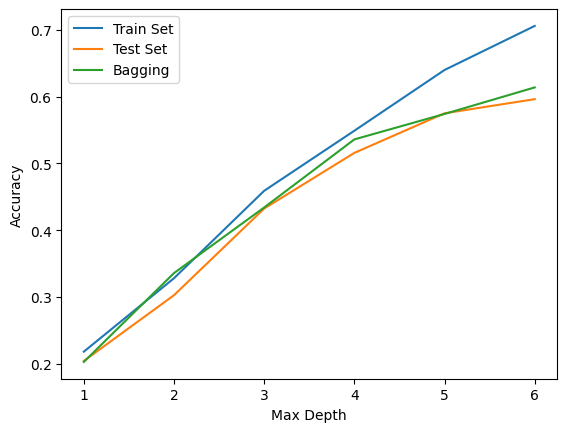

In [24]:
import matplotlib as mpl
import matplotlib.pylab as plt


x = [i for i in range(1, 7)]
plt.plot(x, chart_train1)
plt.plot(x, chart_test1)
plt.plot(x, chart_bag)
plt.ylabel('Accuracy')
plt.xlabel('Max Depth')
plt.legend(['Train Set', 'Test Set', 'Bagging'])

plt.show()

### Random forests

In [20]:
def random_forests_with_decision_trees(X, y, num_trees, max_depth) :
    models = []
    feature_idx = []

    for _ in range(num_trees):
        bootstrap_idx = np.random.choice(len(X), size=len(X), replace=True)
        bootstrap_X, bootstrap_y = X[bootstrap_idx], y[bootstrap_idx]
        feature = np.random.choice(X.shape[1], size=int(np.sqrt(X.shape[1])), replace=False)
        model = make_tree(bootstrap_X[:, feature], bootstrap_y, max_depth)
        models.append(model)
        feature_idx.append(feature)

    return models, feature_idx

In [21]:
def predict_random_forests(models, X, feature_idx) :
    predictions = []
    for model, feature in zip(models, feature_idx):
        pred = [prediction(x[feature], model) for x in X]
        predictions.append(pred)
    final_prediction = np.apply_along_axis(majority_voting, axis=0, arr=predictions)
    return final_prediction

chart_rf = []

for i in range(1, 7) :
    models, feature_idx = random_forests_with_decision_trees(train_X, train_y, num_trees = 6, max_depth = i)
    preds = predict_random_forests(models, test_X, feature_idx)
    acc = np.mean(preds==test_y)
    print('Max Depth {',i,'} : ', acc)
    chart_rf.append(acc)

Max Depth { 1 } :  0.1108
Max Depth { 2 } :  0.3545
Max Depth { 3 } :  0.3655
Max Depth { 4 } :  0.4682
Max Depth { 5 } :  0.4495
Max Depth { 6 } :  0.4931


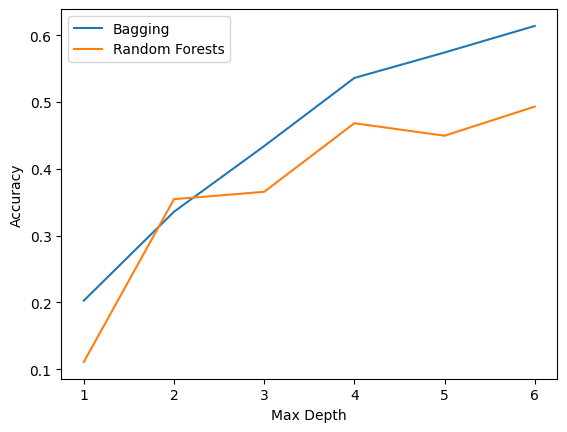

In [23]:
x = [i for i in range (1, 7)]
plt.plot(x, chart_bag)
plt.plot(x, chart_rf)
plt.ylabel('Accuracy')
plt.xlabel('Max Depth')
plt.legend(['Bagging', 'Random Forests'])

plt.show()